In [2]:
import geopandas as gpd 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

For Italian data use these cells

In [3]:
# Replace 'path/to/your/csv/file.csv' with the actual path to your CSV file
data = pd.read_csv('/home/sallyfons/MLEE/italy_heartquakes_1985_2022.csv')

data['datetime'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
data['date_num'] = data['datetime'].apply(lambda x: datetime.timestamp(x))

# Print the data
print(data)
# Checking for missing values
print(data.isnull().sum())

                       date  magnitude  depth  latitude  longitude  \
0       1985-01-02 19:39:30        4.0     10     48.09       7.06   
1       1985-01-02 23:57:43        2.6      6     41.72      13.94   
2       1985-01-03 01:46:16        2.5      6     41.68      13.93   
3       1985-01-04 17:57:40        3.8     10     46.16       7.17   
4       1985-01-05 00:59:54        3.7      5     45.34       6.64   
...                     ...        ...    ...       ...        ...   
102082  2022-12-31 07:17:03        2.0      7     44.01      13.32   
102083  2022-12-31 07:23:49        2.1    153     38.66      15.48   
102084  2022-12-31 09:48:30        2.3     10     44.17      12.32   
102085  2022-12-31 10:30:37        2.3     16     44.20      12.34   
102086  2022-12-31 12:41:16        2.3     14     42.84      13.40   

                  datetime      date_num  
0      1985-01-02 19:39:30  4.735392e+08  
1      1985-01-02 23:57:43  4.735547e+08  
2      1985-01-03 01:46:16  4.

In [103]:
# Define the extent of the specific area
min_latitude = 40.0
max_latitude = 44.0
min_longitude = 10.0
max_longitude = 15.0

# Filter the 'data' DataFrame to include only the points within the specific area
data = data[(data['latitude'] >= min_latitude) & (data['latitude'] <= max_latitude) & (data['longitude'] >= min_longitude) & (data['longitude'] <= max_longitude)]

# Print the points inside the area
print(data)


                      date  magnitude  depth  latitude  longitude  \
1      1985-01-02 23:57:43        2.6      6     41.72      13.94   
2      1985-01-03 01:46:16        2.5      6     41.68      13.93   
6      1985-01-05 09:32:41        2.6      3     43.06      13.14   
8      1985-01-06 04:52:23        2.4     10     43.36      12.54   
9      1985-01-06 05:19:36        2.3     10     43.37      12.54   
...                    ...        ...    ...       ...        ...   
102071 2022-12-29 20:31:30        2.2      8     43.99      13.29   
102075 2022-12-30 01:54:46        2.3      9     43.96      13.29   
102077 2022-12-30 14:22:33        2.0     28     43.09      14.16   
102081 2022-12-31 01:37:35        3.1      9     43.98      13.31   
102086 2022-12-31 12:41:16        2.3     14     42.84      13.40   

            date_num  
1       4.735547e+08  
2       4.735612e+08  
6       4.737620e+08  
8       4.738315e+08  
9       4.738332e+08  
...              ...  
102071  1.

For Turkey earthquakes use this cell

In [4]:
# Replace 'path/to/your/csv/file.csv' with the actual path to your CSV file
data = pd.read_csv('/home/sallyfons/MLEE/turkey_earthquakes(1915-2021).csv')

# Translate the header names from Turkish to English
data = data.rename(columns={'Deprem Kodu': 'Earthquake Code', 'Olus tarihi': 'date', 'Olus zamani': 'time', 'Enlem': 'latitude', 'Boylam': 'longitude', 'Derinlik': 'depth', 'Tip': 'Type (eq/ex)', 'Yer': 'Location'})


# Convert the date and time columns to datetime format
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'], format='%d/%m/%Y %H:%M:%S')

# Sort the data by date
data = data.sort_values('datetime', ascending=True)
# Filter out rows with missing or invalid dates

data = data[data['datetime'].notnull()]

# Convert the datetime column to numeric format
data['date_num'] = data['datetime'].apply(lambda x: datetime.timestamp(x))



print(f' Numeric dates that are NaN: {data["date_num"].isnull().sum()}')
print(f' Latitude that are NaN: {data["latitude"].isnull().sum()}')
print(f' Moment Magnitude that are NaN or 0: {(data["Mw"].isnull() | (data["Mw"] == 0)).sum()}')
print(f' Local Magnitude that are NaN or 0: {(data["ML"].isnull() | (data["ML"] == 0)).sum()}')
count = ((data['Mw'].isnull() | (data['Mw'] == 0)) & (data['ML'].isnull() | (data['ML'] == 0))).sum()
print(f'Number of rows where both "Mw" and "ML" are either 0 or NaN: {count}')
print(f' Depths that are NaN: {data["depth"].isnull().sum()}')

#Due to high number of NaN in Mw, ML will be used. Also the same one as in the Italy Earthquake Prediction model
data = data.rename(columns={'ML': 'magnitude'})
# Drop rows where the values of ML are NaN
data = data.dropna(subset=['magnitude'], how='any')

# Drop rows where the values of ML are 0
data = data[data['magnitude'] != 0]

# Print the data
print(data)
print(f' Moment Magnitude that are NaN or 0: {(data["Mw"].isnull() | (data["Mw"] == 0)).sum()}')

 Numeric dates that are NaN: 0
 Latitude that are NaN: 0
 Moment Magnitude that are NaN or 0: 12894
 Local Magnitude that are NaN or 0: 8491
Number of rows where both "Mw" and "ML" are either 0 or NaN: 8440
 Depths that are NaN: 0
          No  Earthquake Code        date      time  latitude  longitude  \
6087   17370     1.915020e+13  14/02/1915  08:20:01   38.8000    42.5000   
9099   17369     1.915020e+13  28/02/1915  12:47:02   37.7000    43.1000   
4392   17368     1.915040e+13  01/04/1915  05:41:05   40.5000    44.5000   
3745   17367     1.915050e+13  19/05/1915  04:48:02   37.6200    39.4700   
4672   17365     1.915120e+13  25/12/1915  06:06:09   36.4700    36.1400   
...      ...              ...         ...       ...       ...        ...   
14315      5     2.020120e+13  27/12/2020  20:08:37   38.4172    39.1482   
9683       4     2.020120e+13  30/12/2020  13:40:12   37.7960    26.4165   
13291      3     2.020120e+13  30/12/2020  18:45:13   36.4918    28.7092   
694      

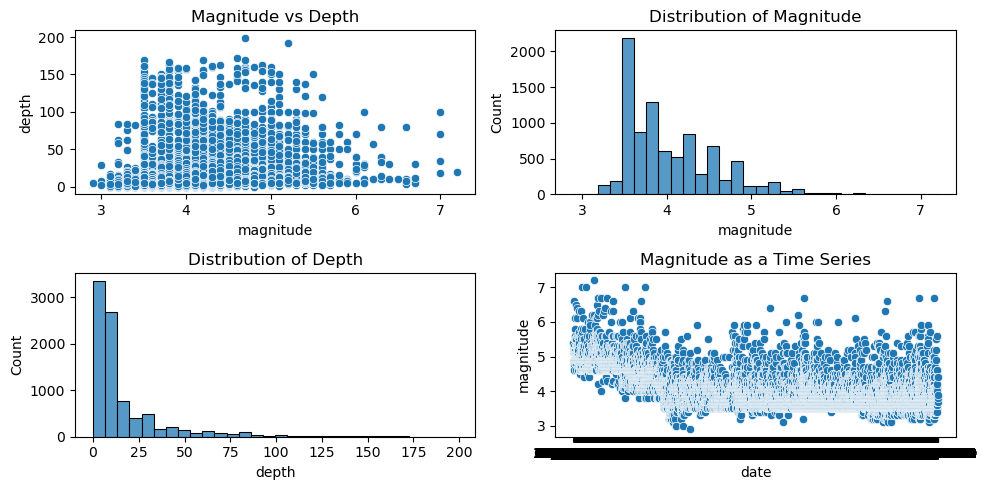

In [111]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# Scatter plot of magnitude vs depth
sns.scatterplot(x='magnitude', y='depth', data=data, ax=axes[0, 0])
axes[0, 0].set_title('Magnitude vs Depth')

# Distribution plot of magnitude
sns.histplot(data['magnitude'], bins=30, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Magnitude')

# Distribution plot of depth
sns.histplot(data['depth'], bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Depth')

# Scatter plot of magnitude as a time series
sns.scatterplot(x='date', y='magnitude', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Magnitude as a Time Series')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

/tmp/ipykernel_1135/1248811713.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

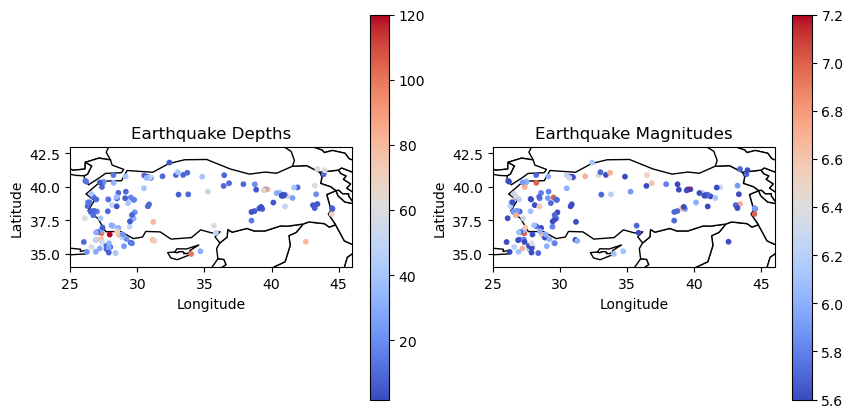

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the country borders shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a GeoDataFrame from the latitude and longitude columns
geometry = gpd.points_from_xy(data['longitude'], data['latitude'])
gdf_eq = gpd.GeoDataFrame(data, geometry=geometry)

# Create a figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Set the x-axis and y-axis limits based on the data
ax[0].set_xlim(data['longitude'].min() - 1, data['longitude'].max() + 1)
ax[0].set_ylim(data['latitude'].min() - 1, data['latitude'].max() + 1)
ax[1].set_xlim(data['longitude'].min() - 1, data['longitude'].max() + 1)
ax[1].set_ylim(data['latitude'].min() - 1, data['latitude'].max() + 1)
# Plot the country borders as a background map
world.plot(ax=ax[0], color='white', edgecolor='black')
world.plot(ax=ax[1], color='white', edgecolor='black')
# Set the aspect ratio of the plot
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
# Plot the data points

# Filter the data to include only magnitudes higher than 4.5
filtered_data = gdf_eq[gdf_eq['magnitude'] > 5.5]

# Plot the filtered data points
filtered_data.plot(ax=ax[0], column='depth', cmap='coolwarm', markersize=10, legend=True)
filtered_data.plot(ax=ax[1], column='magnitude', cmap='coolwarm', markersize=10, legend=True)
#gdf_eq.plot(ax=ax[0], column='depth', cmap='coolwarm', markersize= 10 , legend=True)
#gdf_eq.plot(ax=ax[1], column='magnitude', cmap='coolwarm', markersize=10, legend=True)

# Set the plot title and axis labels
ax[0].set_title('Earthquake Depths')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[1].set_title('Earthquake Magnitudes')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

# Show the colorbar
plt.colorbar(ax= ax[0], label='Depth')
plt.colorbar(ax=ax[1], label='Magnitude')

# Show the plot
plt.show()


Introduce seismic parameters from date/magnitude data

In [5]:
from datetime import timedelta
#Cut-off Magnitude
cutoff_mag = 5.5
min_mag = 3.5

# Add a new column 'HighMagnitude' based on the magnitude
data['HighMagnitude'] = data['magnitude'].apply(lambda x: 1 if x >= cutoff_mag else 0)

# Print the updated DataFrame
print(data['HighMagnitude'].value_counts())

#Define a function to check if there is a high magnitude earthquake in the next 7 days
def check_next_week_high_magnitude(row):
    next_week = row['datetime'] + timedelta(days=7)
    next_week_data = data[(data['datetime'] > row['datetime']) & (data['datetime'] <= next_week)]
    return 1 if any(next_week_data['magnitude'] >= cutoff_mag) else 0


# Define a function to compute the maximum magnitude in the last 7 days
def compute_max_magnitude(row):
    last_week = row['datetime'] - timedelta(days=7)
    last_week_data = data[(data['datetime'] > last_week) & (data['datetime'] <= row['datetime'])]
    return last_week_data['magnitude'].max()



# Apply the function to create the 'NextWeekHighMagnitude' column
data['NextWeekHighMagnitude'] = data.apply(check_next_week_high_magnitude, axis=1)

#Apply the function to create the Max Magnitude column 'x6
data['x6'] = data.apply(compute_max_magnitude, axis=1)
# Add a new column 'TimeElapsed' that calculates the time elapsed between each event
data['TimeElapsed'] = data['date_num'].diff()
data['TimeElapsed'] = data['TimeElapsed'].fillna(0)

# Print the updated DataFrame
print(data.head())

# Print the updated DataFrame
print(data['NextWeekHighMagnitude'].value_counts())
print(data[10100:10107])




HighMagnitude
0    8702
1     177
Name: count, dtype: int64
         No  Earthquake Code        date      time  latitude  longitude  \
6087  17370     1.915020e+13  14/02/1915  08:20:01     38.80      42.50   
9099  17369     1.915020e+13  28/02/1915  12:47:02     37.70      43.10   
4392  17368     1.915040e+13  01/04/1915  05:41:05     40.50      44.50   
3745  17367     1.915050e+13  19/05/1915  04:48:02     37.62      39.47   
4672  17365     1.915120e+13  25/12/1915  06:06:09     36.47      36.14   

      depth   xM  MD  magnitude  ...  Ms  Mb  Type (eq/ex)  \
6087   30.0  5.7   5        5.4  ...   6   5            Ke   
9099   30.0  5.5   5        5.2  ...   5   5            Ke   
4392   35.0  4.9   5        4.8  ...   5   5            Ke   
3745   10.0  5.5   5        5.3  ...   5   5            Ke   
4672   10.0  5.4   5        5.1  ...   5   5            Ke   

                                             Location            datetime  \
6087   CEMALETTIN-AHLAT (BITLIS) [South

In [6]:
#Adding more parameters

data['local_b_value'] = 0.4343 / (data['magnitude'].rolling(window=50, min_periods=1).mean() - min_mag)
data['meanM'] = data['magnitude'].rolling(window=50, min_periods=1).mean()
data['x7'] = 10 ** (-3 * data['local_b_value'])
data['E'] = 10 ** (1.5 * data['magnitude'] + 11.8)
data['E'] = data['E'].apply(np.sqrt)

# Print the head of the updated DataFrame
print(data.head())
# Calculate T
#data['T'] = data.groupby((data['magnitude'] >= 5.0).cumsum())['date_num'].transform(lambda x: x.max() - x.min())

# Print the head of the updated DataFrame
print(data.head())
print(data[['magnitude', 'date', 'local_b_value', 'x6', 'x7']][9580:9589])
print(data[['magnitude', 'date', 'local_b_value', 'x6', 'x7']][10101:10106])
print(data[data['magnitude'] > 5][['date', 'local_b_value', 'x6', 'x7']].head(10))



         No  Earthquake Code        date      time  latitude  longitude  \
6087  17370     1.915020e+13  14/02/1915  08:20:01     38.80      42.50   
9099  17369     1.915020e+13  28/02/1915  12:47:02     37.70      43.10   
4392  17368     1.915040e+13  01/04/1915  05:41:05     40.50      44.50   
3745  17367     1.915050e+13  19/05/1915  04:48:02     37.62      39.47   
4672  17365     1.915120e+13  25/12/1915  06:06:09     36.47      36.14   

      depth   xM  MD  magnitude  ...            datetime      date_num  \
6087   30.0  5.7   5        5.4  ... 1915-02-14 08:20:01 -1.731862e+09   
9099   30.0  5.5   5        5.2  ... 1915-02-28 12:47:02 -1.730636e+09   
4392   35.0  4.9   5        4.8  ... 1915-04-01 05:41:05 -1.727897e+09   
3745   10.0  5.5   5        5.3  ... 1915-05-19 04:48:02 -1.723753e+09   
4672   10.0  5.4   5        5.1  ... 1915-12-25 06:06:09 -1.704740e+09   

      HighMagnitude NextWeekHighMagnitude   x6 TimeElapsed  local_b_value  \
6087              0        

Beginning of the first Machine Learning Algorithm

In [7]:
#import relevant Modules for ML
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score

Using RandomForestClassifier 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   9.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=  13.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   8.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   8.4s
[CV] END max_

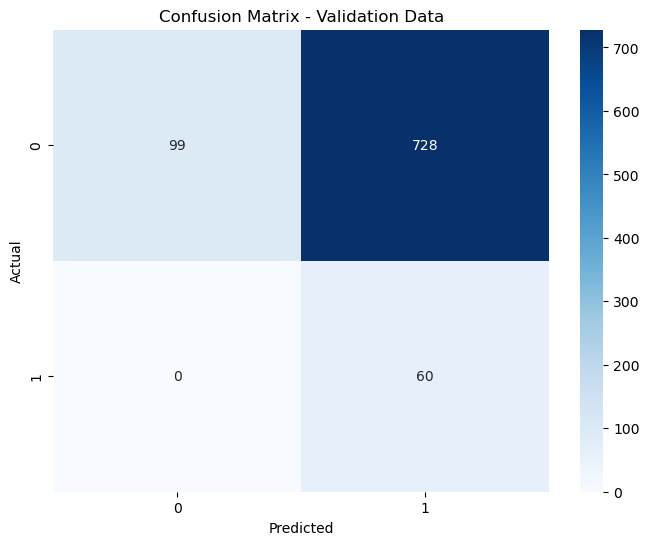

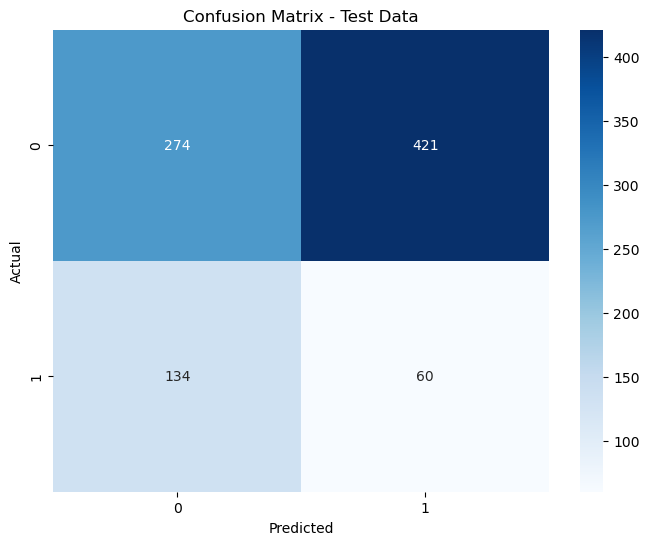

In [15]:

# Define predictors
#X = data[['date_num', 'depth', 'magnitude', 'x6', 'x7', 'meanM', 'E', 'local_b_value', 'TimeElapsed']]
#y = data[['NextWeekHighMagnitude']]

# Split the dataset into training and test sets 
# Define the size of the training, validation, and testing sets
train_size = int(0.8 * len(data))  # 70% of the data for training
val_size = int(0.1 * len(data))  # 20% of the data for validation
test_size = len(data) - train_size - val_size  # Remaining data for testing

# # Split the data into training, validation, and testing sets
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# # Separate the predictors (X) and the target variable (y) for each set
X_train = train_data[['date_num', 'depth', 'latitude', 'longitude', 'magnitude', 'x6', 'x7', 'meanM', 'E', 'local_b_value', 'TimeElapsed']]
y_train = train_data[['NextWeekHighMagnitude']]
y_train = y_train.values.ravel()

X_val = val_data[['date_num', 'depth', 'latitude', 'longitude', 'magnitude', 'x6', 'x7', 'meanM', 'E', 'local_b_value', 'TimeElapsed']]
y_val = val_data[['NextWeekHighMagnitude']]
y_val = y_val.values.ravel()

X_test = test_data[['date_num', 'depth', 'latitude', 'longitude', 'magnitude', 'x6', 'x7', 'meanM', 'E', 'local_b_value', 'TimeElapsed']]
y_test = test_data[['NextWeekHighMagnitude']]
y_test = y_test.values.ravel()

#Normalize dataset
scaler  = StandardScaler()
scaler.fit(X_train)

# #applying the transform on our datasets
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Split the dataset into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the training set into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [200],
    'max_depth': [None, 30],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 3]
}

# Initialize the Random Forest Regressor
rfc = GradientBoostingClassifier()

#Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring= 'recall', verbose=2)

#Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Extract best hyperparameters from 'grid_search'
best_rfc_params = grid_search.best_params_
print("Best hyperparameters:\n", best_rfc_params)

# Extract best model from 'grid_search'
best_rfc_model = grid_search.best_estimator_
print("\nBest model:\n", best_rfc_model)

y_val_pred = best_rfc_model.predict(X_val)
y_test_pred = best_rfc_model.predict(X_test)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print('Recall Score:', recall_score(y_test, y_test_pred))

# Calculate the confusion matrix
cmv = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmv, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Data')
plt.show()




Trying Deep Learning Algorithms

Epoch 1/20
222/222 [==============================] - 3s 9ms/step - loss: 0.8265 - accuracy: 0.5817 - val_loss: 0.3817 - val_accuracy: 0.9008
Epoch 2/20
222/222 [==============================] - 2s 8ms/step - loss: 0.7020 - accuracy: 0.6330 - val_loss: 0.5259 - val_accuracy: 0.7170
Epoch 3/20
222/222 [==============================] - 2s 9ms/step - loss: 0.6415 - accuracy: 0.6618 - val_loss: 0.5299 - val_accuracy: 0.7407
Epoch 4/20
222/222 [==============================] - 2s 9ms/step - loss: 0.6119 - accuracy: 0.6690 - val_loss: 0.5072 - val_accuracy: 0.7678
Epoch 5/20
222/222 [==============================] - 2s 9ms/step - loss: 0.5870 - accuracy: 0.6825 - val_loss: 0.5236 - val_accuracy: 0.7542
Epoch 6/20
222/222 [==============================] - 2s 10ms/step - loss: 0.5766 - accuracy: 0.6897 - val_loss: 0.5026 - val_accuracy: 0.7723
Epoch 7/20
222/222 [==============================] - 2s 9ms/step - loss: 0.5602 - accuracy: 0.6928 - val_loss: 0.5567 - val_accuracy: 0.7283
Epoch

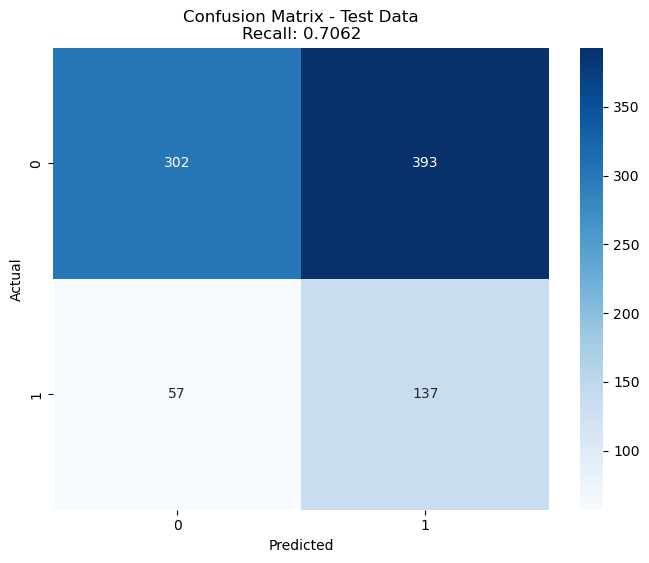

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define the ANN model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(11,)))
model.add(BatchNormalization())  # Adding Batch Normalization
model.add(Dropout(0.5))  # Adding Dropout to reduce overfitting
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Train the model
history = model.fit(X_train, y_train, class_weight=class_weights_dict, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test set
y_test_pred_probs = model.predict(X_test)

# Get the predicted classes
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Calculate recall
recall = recall_score(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Test Data\nRecall: {recall:.4f}')
plt.show()


Epoch 1/50
222/222 [==============================] - 5s 14ms/step - loss: 0.6825 - accuracy: 0.6583 - val_loss: 0.4357 - val_accuracy: 0.8534
Epoch 2/50
222/222 [==============================] - 3s 12ms/step - loss: 0.6012 - accuracy: 0.6928 - val_loss: 0.4941 - val_accuracy: 0.8061
Epoch 3/50
222/222 [==============================] - 3s 11ms/step - loss: 0.5837 - accuracy: 0.7017 - val_loss: 0.4910 - val_accuracy: 0.8467
Epoch 4/50
222/222 [==============================] - 2s 8ms/step - loss: 0.5845 - accuracy: 0.7132 - val_loss: 0.4370 - val_accuracy: 0.8275
Epoch 5/50
222/222 [==============================] - 2s 9ms/step - loss: 0.5848 - accuracy: 0.7055 - val_loss: 0.4659 - val_accuracy: 0.8072
Epoch 6/50
222/222 [==============================] - 3s 13ms/step - loss: 0.5739 - accuracy: 0.7100 - val_loss: 0.3869 - val_accuracy: 0.8613
Epoch 7/50
222/222 [==============================] - 2s 11ms/step - loss: 0.5708 - accuracy: 0.7152 - val_loss: 0.5643 - val_accuracy: 0.7351
E

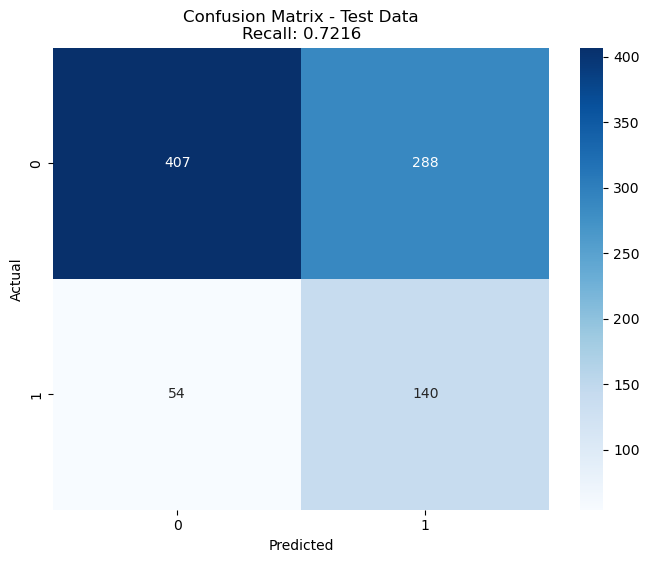

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape input data for 1D CNN
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the 1D CNN model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(11, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_cnn, y_train, class_weight=class_weights_dict, 
                    validation_data=(X_val_cnn, y_val), epochs=50, batch_size=32,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_cnn, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test set
y_test_pred_probs = model.predict(X_test_cnn)

# Get the predicted classes
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Calculate recall
recall = recall_score(y_test, y_test_pred)
print('Recall:', recall)

# Calculate F1 score
f1 = f1_score(y_test, y_test_pred)
print('F1 score:', f1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Test Data\nRecall: {recall:.4f}')
plt.show()

In [34]:
# Define predictors
X = data[['latitude', 'longitude', 'depth', 'date_num']]
y = data[['magnitude']]
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#Normalize dataset
#import StandardScaler object
# scaler  = StandardScaler()
# scaler.fit(X_train)

# #applying the transform on our datasets
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

#initializing a random forest regressor on our dataset with standard parameters: this will be fine tuned later
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42) 
# rf_model.fit(X_train, y_train)
# y_pred = rf_model.predict(X_test) 

# Define the parameter grid to search
param_grid = {
    'n_estimators': [200],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [4]
}

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, 
                           scoring='neg_root_mean_squared_error', cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Make predictions on the validation set
y_val_pred = best_rf_model.predict(X_val)

# Evaluate the model on the validation set
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
print(f'Mean Squared Error on Validation Set: {mse_val}')
print(f'Root Mean Squared Error on Validation Set: {rmse_val}')

#Evaluate on the training set?
mse_tra = mean_squared_error(y_train, best_rf_model.predict(X_train))
rmse_tra = np.sqrt(mse_tra)
print(f'Mean Squared Error on Training Set: {mse_tra}')
print(f'Root Mean Squared Error on Training Set: {rmse_tra}')

/home/sallyfons/anaconda3/envs/instance/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/sallyfons/anaconda3/envs/instance/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/sallyfons/anaconda3/envs/instance/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/sallyfons/anaconda3/envs/instance/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A co

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error on Validation Set: 0.12823258241324026


In [35]:
#Test the model and make the predictions
y_pred = best_rf_model.predict(X_test)


EVALUATING THE MODEL (For Random Forest Regression, Now obsolete)

Mean Squared Error: 0.1250877383109212
R-squared: 0.3242961061151389
Root Mean Squared Error: 0.3536774495368926
Mean Squared Error on Validation Set: 0.12823258241324026
Root Mean Squared Error on Validation Set: 0.35809577268272835
Mean Squared Error on Training Set: 0.08238935269385833
Root Mean Squared Error on Training Set: 0.28703545546475323


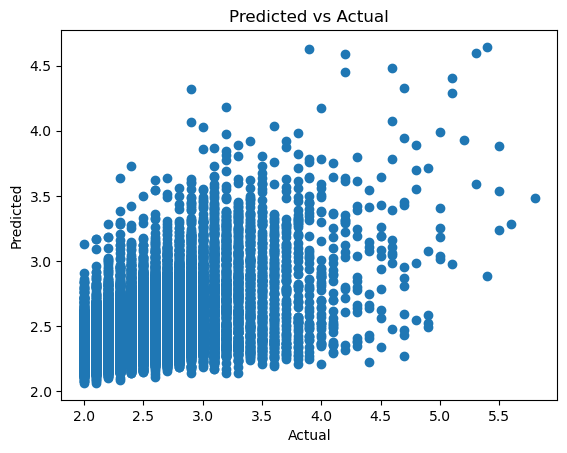

In [38]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
# Calculate the R2 score
r2 = r2_score(y_test, y_pred)
#Calculating the RMSE
rmse = np.sqrt(mse)
#Calculating MAPE
#mape = np.mean(np.abs((y_test - y_pred)/y_test))*100

# Print the metrics
print("Mean Squared Error:", mse)
print(f'R-squared: {r2}')
print(f'Root Mean Squared Error: {rmse}')
#print(f'Mean Absolute Percentage Error: {mape}')

# Evaluate the model on the validation set
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
print(f'Mean Squared Error on Validation Set: {mse_val}')
print(f'Root Mean Squared Error on Validation Set: {rmse_val}')

#Evaluate on the training set?
mse_tra = mean_squared_error(y_train, best_rf_model.predict(X_train))
rmse_tra = np.sqrt(mse_tra)
print(f'Mean Squared Error on Training Set: {mse_tra}')
print(f'Root Mean Squared Error on Training Set: {rmse_tra}')

# Create a scatter plot of y_pred vs y_test
plt.scatter(y_test, y_pred)

# Set the plot title and axis labels
plt.title('Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Show the plot
plt.show()


CALCULATING GUTENBERG-RICHTER VALUES

a value: 6.556794346789255
b value: -1.0702480300407853
coefficients: [-1.07024803  6.55679435]


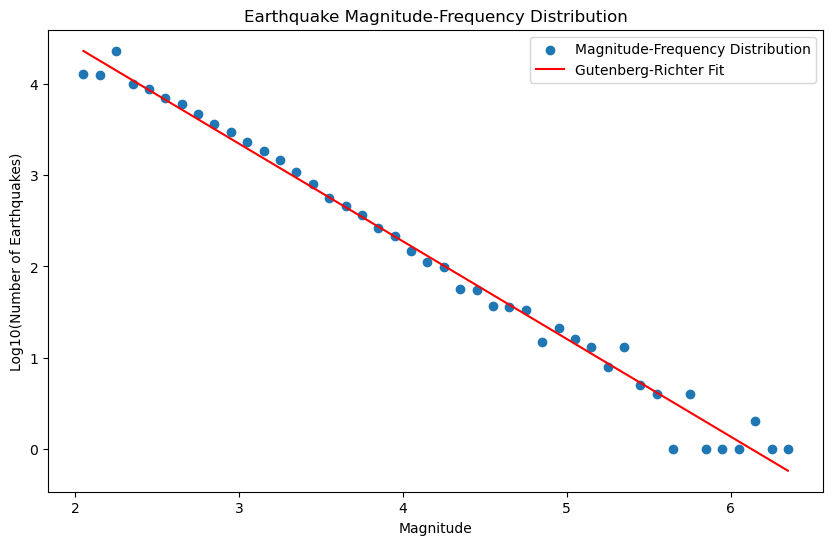

In [10]:
#Count number of earthquakes for each magnitude & extract vaues from midpoint of bins
mag_counts, mag_bins = np.histogram(data['magnitude'], bins=np.arange(data['magnitude'].min(), data['magnitude'].max(), 0.1))
mag_values = (mag_bins[:-1] + mag_bins[1:]) / 2

# Perform linear regression on the log-transformed data
log_mag_counts = np.log10(np.where(mag_counts > 0, mag_counts, 1))

# Fit a linear function to the log-transformed data
coeff = np.polyfit(mag_values, log_mag_counts, 1)
b, a = coeff

# Display the results
print(f"a value: {a}")
print(f"b value: {b}")
print(f"coefficients: {coeff}")

# Plot the earthquake magnitude-frequency distribution
plt.figure(figsize=(10, 6))
plt.scatter(mag_values, log_mag_counts, label='Magnitude-Frequency Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Number of Earthquakes)')
plt.title('Earthquake Magnitude-Frequency Distribution')

# Plot the fitted curve
plt.plot(mag_values, a + b * mag_values, color='red', label='Gutenberg-Richter Fit')

# Display the legend
plt.legend()

# Show the plot
plt.show()
